**ARI** = L'indice de Rand est une mesure de similarité entre deux partitions d'un ensemble. Il est principalement utilisé en catégorisation automatique. Son principe est de mesurer la consistance (le taux d'accord) entre deux partitions. 

# 1 : Librairies et options

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageEnhance, ImageOps, ImageFilter
import seaborn as sns
import tqdm

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
import cv2
from sklearn import cluster, metrics
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn import manifold, decomposition


from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>")) # Largeur écran
pd.set_option('display.max_columns', 500)
pd.set_option('mode.chained_assignment', None) # Pour ne pas avoir de message d'erreur quand on crée nouvelle df à partir d'une autre (app)

# 2 : Ouverture du fichier et test transformations d'images

## 2.1 : Ouverture du fichier:

In [2]:
df = pd.read_csv('DataP6.csv')

## 2.2 : Transformation images

In [3]:
# Réduction d'une image trop lourde pour l'analyse :

def get_num_pixels(filepath):
    width, height = Image.open(filepath).size
    return width*height

index = []
for i in range(0, len(df)):
    LimitPixel = 89478485 # info de DecompressionBombWarning
    NbPixel = get_num_pixels("Flipkart/Images/"+df['image'][i])
    if NbPixel > LimitPixel:
        index.append(i)
print('Les photos ayant une taille trop grandes sont les photos en index :', index)

for j in index :
    image = df['image'].iloc[j : j+1].values[0]
    imageLue = Image.open("Flipkart/Images/" + image)
    dim = imageLue.size
    print(dim)
    imagedif = image.split('.')[0] + '2' + '.png'
    imageComp = imageLue.resize((int(dim[0]/1.1),int(dim[1]/1.1)))
    imageComp.save("Flipkart/Images/" + imagedif)
    dimComp = imageComp.size
    print(dimComp)
    
    df['image'].iloc[j : j+1] = df.iloc[j : j+1]['image'].replace(image, imagedif)
    df['image'].iloc[j : j+1]

C:\Users\Johan\Formation DS OPC\Projet 3\env\Lib\site-packages\PIL\Image.py:3167: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Les photos ayant une taille trop grandes sont les photos en index : [677]
(8484, 11042)
(7712, 10038)


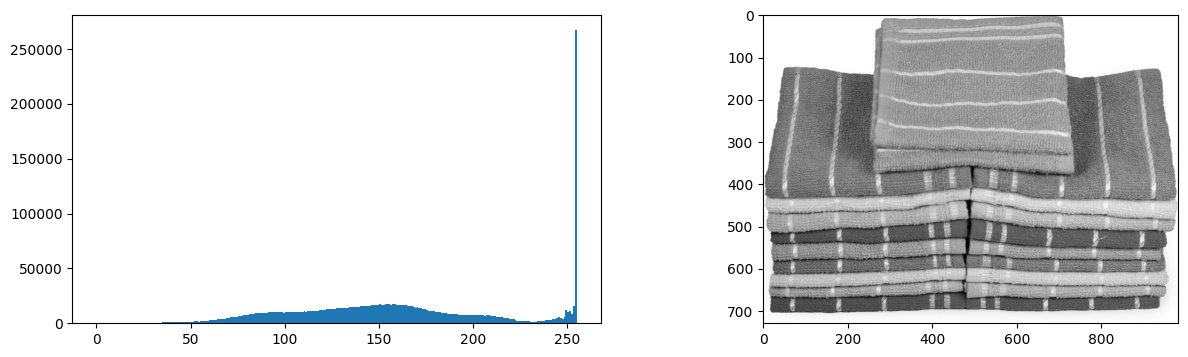

In [4]:
# Ouverture d'une image :
img = Image.open("Flipkart/Images/" + '64d5d4a258243731dc7bbb1eef49ad74.jpg')

# Passage en noir et blanc :
filter = ImageEnhance.Color(img)
img = filter.enhance(0)
imgarray = np.array(img)

# Niveau de gris :
plt.subplots (1,2, figsize = (15,4))
plt.subplot(121)
n, bins, patches = plt.hist(imgarray.flatten(), bins=range(256))
plt.subplot(122)
plt.imshow(img)
plt.show()

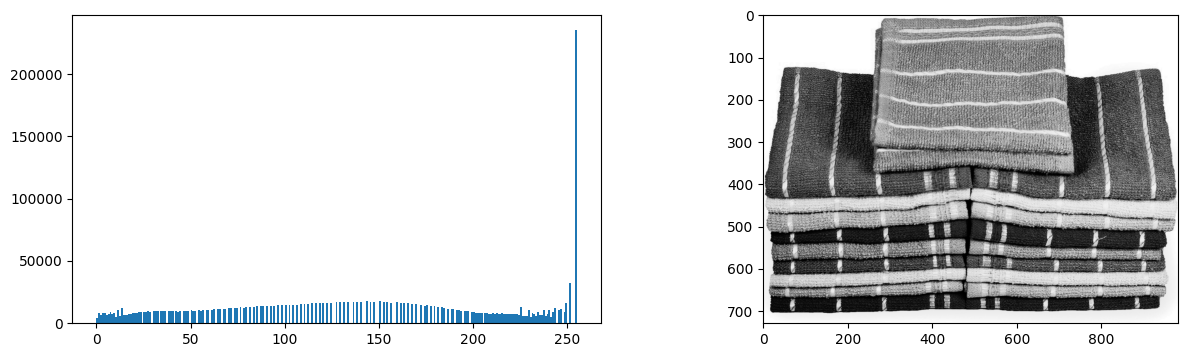

In [5]:
# Equalization :
img2 = ImageOps.equalize(img, mask = None)
imgarray2 = np.array(img2)

# Niveau de gris :
plt.subplots (1,2, figsize = (15,4))
plt.subplot(121)
n, bins, patches = plt.hist(imgarray2.flatten(), bins=range(256))
plt.subplot(122)
plt.imshow(img2)
plt.show()

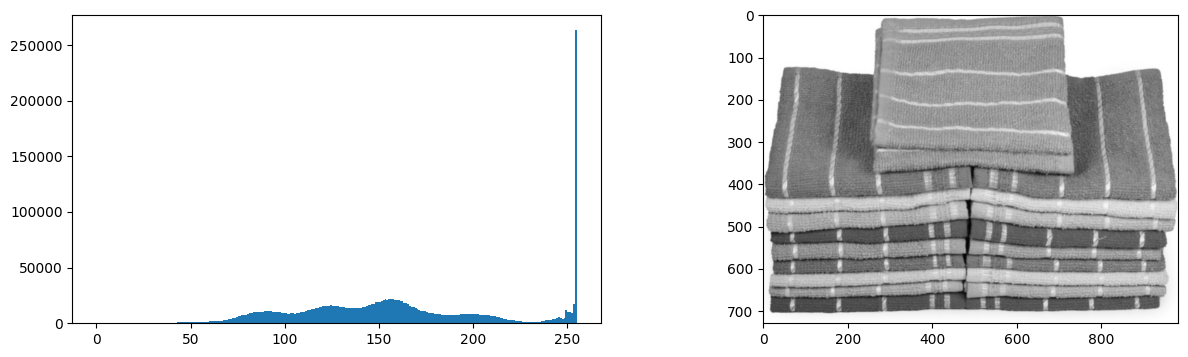

In [6]:
# Filtrage du bruit:
img3 = img.filter(ImageFilter.BoxBlur(1))
imgarray3 = np.array(img3)

# Niveau de gris :
plt.subplots (1,2, figsize = (15,4))
plt.subplot(121)
n, bins, patches = plt.hist(imgarray3.flatten(), bins=range(256))
plt.subplot(122)
plt.imshow(img3)
plt.show()

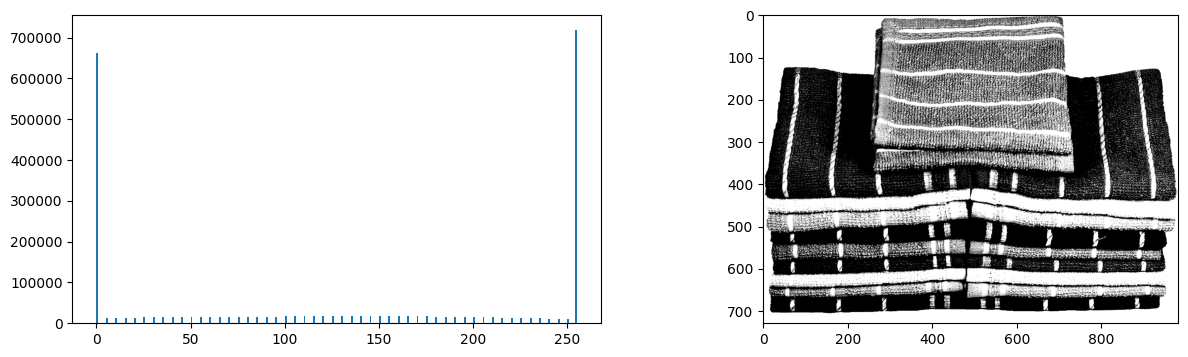

In [7]:
# Contrast :
enhancer = ImageEnhance.Contrast(img)
img4 = enhancer.enhance(5)
imgarray4 = np.array(img4)

# Niveau de gris :
plt.subplots (1,2, figsize = (15,4))
plt.subplot(121)
n, bins, patches = plt.hist(imgarray4.flatten(), bins=range(256))
plt.subplot(122)
plt.imshow(img4)
plt.show()

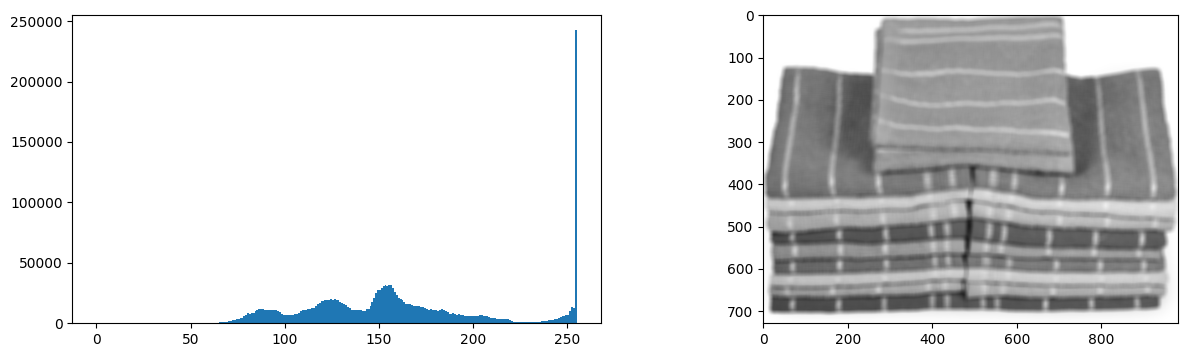

In [8]:
# Floutage:
img5 = img.filter(ImageFilter.BoxBlur(6))
imgarray5 = np.array(img5)

# Niveau de gris :
plt.subplots (1,2, figsize = (15,4))
plt.subplot(121)
n, bins, patches = plt.hist(imgarray5.flatten(), bins=range(256))
plt.subplot(122)
plt.imshow(img5)
plt.show()

# 3 : Définitions 

In [9]:
# Split des données :

def TrainTest (X, y) :
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, random_state = 42, stratify = y)
    return X_train, X_test, y_train, y_test

In [10]:
# Regression Logistic :

def RL (X_train, y_train, X_test, y_test) :
    modelLR = LogisticRegression(max_iter = 1000).fit(X_train, y_train)

    AccuracyTrain = round(modelLR.score(X_train,y_train),3)
    AccuracyTest = round(modelLR.score(X_test,y_test),3)
    
    return AccuracyTrain, AccuracyTest

In [11]:
# Arbre de décision :

def DecisionTree (X_train, y_train, X_test, y_test) :
    dico = {'max_depth' : range(2,5), "min_samples_leaf" : [5, 10, 15, 20]}
    SKF = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 42).split(X_train, y_train)
    modelDTC = GridSearchCV(DecisionTreeClassifier(random_state = 42), dico, refit=True, cv = SKF).fit(X_train, y_train)

    AccuracyTrain = round(modelDTC.score(X_train,y_train),3)
    AccuracyTest = round(modelDTC.score(X_test,y_test),3)
    
    return AccuracyTrain, AccuracyTest

In [12]:
# KNN :

def KNN (X_train, y_train, X_test, y_test) :
    dico = {'n_neighbors' : range(2,50), 'weights' : ['uniform', 'distance']}
    SKF = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 42).split(X_train, y_train)
    modelKNN = GridSearchCV(KNeighborsClassifier(), dico, refit=True, cv = SKF).fit(X_train, y_train)

    AccuracyTrain = round(modelKNN.score(X_train,y_train),3)
    AccuracyTest = round(modelKNN.score(X_test,y_test),3)
    
    return AccuracyTrain, AccuracyTest

In [13]:
# Random Forest :

def RandomForest (X_train, y_train, X_test, y_test) :
    dico = {'max_depth' : range(3,6), 'n_estimators' : [300,400,500], 'min_samples_leaf': [4, 5, 6]}
    SKF = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 42).split(X_train, y_train)
    modelRF = GridSearchCV(RandomForestClassifier(random_state = 42), dico, refit=True, cv = SKF).fit(X_train, y_train)

    AccuracyTrain = round(modelRF.score(X_train,y_train),3)
    AccuracyTest = round(modelRF.score(X_test,y_test),3)
    
    return AccuracyTrain, AccuracyTest

In [14]:
# Suport Vecteur Machine :

def SVM (X_train, y_train, X_test, y_test) :
    dico = {'C': np.logspace(-2, 5, 6), 'gamma': np.logspace(-4, 1, 6)}
    SKF = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 42).split(X_train, y_train)
    modelSVC = GridSearchCV(SVC(), dico, cv = SKF, refit=True).fit(X_train, y_train)

    AccuracyTrain = round(modelSVC.score(X_train,y_train),3)
    AccuracyTest = round(modelSVC.score(X_test,y_test),3)
    
    return AccuracyTrain, AccuracyTest

In [15]:
# Réduction des variables par PCA :

def PCA (value, nb):
    pca = decomposition.PCA(n_components = nb)
    feat_pca= pca.fit_transform(value)
    return feat_pca

In [16]:
# Réduction des variables par TSNE (en 2D pour visualisation des clusters) :

def TSNE (value) : 
    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, init='random', random_state=6)
    X_tsne = tsne.fit_transform(value)
    return X_tsne

In [17]:
# Graphique 2D sur TSNE clusters reels et clusters via KMeans :

def graphTSNE (X_tsne) : 
    df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
    df_tsne["class"] = df['TreeNiv1']

    plt.figure(figsize=(8,5))
    sns.scatterplot(
        x="tsne1", y="tsne2", hue="class", palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
        data = df_tsne, legend="brief")

    plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
    plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
    plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
    plt.legend(prop={'size': 14}) 

    plt.show()

In [18]:
# Graphiques avec les vrais labels et les labels issus d'un KMeans :

def graphsTSNE (X_tsne) : 
    # Graphiques vraies classes :
    df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
    df_tsne["class"] = df['TreeNiv1']

    plt.subplots(1, 3, figsize=(20,5))
    plt.subplot(131)
    sns.scatterplot(
        x="tsne1", y="tsne2", hue="class", palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
        data = df_tsne, legend="brief")

    plt.title('TSNE selon les vraies classes :', fontsize = 15, fontweight = 'bold')
    plt.xlabel('tsne1', fontsize = 15, fontweight = 'bold')
    plt.ylabel('tsne2', fontsize = 15, fontweight = 'bold')
    plt.legend(prop={'size': 14}) 
    
    # graphiques avec classes faites par KMeans :
    cls = cluster.KMeans(n_clusters=7, n_init=100)
    cls.fit(X_tsne)
    df_tsne["cluster"] = cls.labels_

    plt.subplot(132)
    sns.scatterplot(x="tsne1", y="tsne2", hue="cluster",
    palette = sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne, legend="brief")

    plt.title('TSNE selon les clusters :', fontsize = 15, fontweight = 'bold')
    plt.xlabel('tsne1', fontsize = 15, fontweight = 'bold')
    plt.ylabel('tsne2', fontsize = 15, fontweight = 'bold')
    plt.legend(prop={'size': 14})

    
    # Création de la matrice de confusion :
    labels = df['TreeNiv1']
    conf_mat = metrics.confusion_matrix(labels, cls.labels_)
    corresp = np.argmax(conf_mat, axis=0)
    labels = pd.Series(labels, name="y_true").to_frame()
    labels['y_pred'] = cls.labels_
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x])

    
    cls_labels_transform = np.array(labels['y_pred_transform'])
    labels = df['TreeNiv1']
    conf_mat2 = metrics.confusion_matrix(labels, cls_labels_transform)
    list_labels = df['TreeNiv1Texte'].unique()

    df_cm = pd.DataFrame(conf_mat2, index = [label for label in list_labels], columns = [i for i in "0123456"])
    plt.subplot(133)
    plt.title('Matrice de confusion :', size = 15, fontweight = 'bold' )
    sns.heatmap(df_cm.T, annot=True, cmap="Blues")
    plt.xlabel('Groupes KMeans', fontsize = 15, fontweight = 'bold')
    plt.show()
    
    print("La mesure de ARI est de {} pour ce modèle d'extraction des features.".format(round(metrics.adjusted_rand_score(labels, cls.labels_),3)))

# 4 : Etude de la colonnes Image

## 4.1 : SIFT

### 4.1.1 : Extraction des features des images et transformation

In [19]:
# Extraction des labels :
path = 'Flipkart/Images/'

sift_keypoints = []
sift = cv2.SIFT_create(1000)

for num in tqdm.tqdm(range(0, len(df['image']))) :
    image = cv2.imread(path + df['image'][num],0) # convert in gray
    res = cv2.equalizeHist(image)   # equalize image histogram
    kp, des = sift.detectAndCompute(res, None)
    sift_keypoints.append(des)

sift_keypoints_by_img = np.asarray(sift_keypoints)
sift_keypoints_all    = np.concatenate(sift_keypoints_by_img, axis=0)

100%|██████████████████████████████████████████████████████████████████████████████| 1050/1050 [10:39<00:00,  1.64it/s]
C:\Users\Johan\AppData\Local\Temp\ipykernel_5808\2452953889.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sift_keypoints_by_img = np.asarray(sift_keypoints)


In [20]:
# Determination number of clusters
k = int(round(np.sqrt(len(sift_keypoints_all)),0))

# Clustering
kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0)
kmeans.fit(sift_keypoints_all)

C:\Users\Johan\Formation DS OPC\Projet 3\env\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


MiniBatchKMeans(init_size=2985, n_clusters=995, random_state=0)

In [21]:
# Creation of histograms (features)
def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist


# Creation of a matrix of histograms
hist_vectors=[]

for i, image_desc in enumerate(sift_keypoints_by_img) :
    hist = build_histogram(kmeans, image_desc, i) #calculates the histogram
    hist_vectors.append(hist) #histogram is the feature vector

im_features = np.asarray(hist_vectors)

### 4.1.2 : Réduction des dimensions et etude graphique des clusters

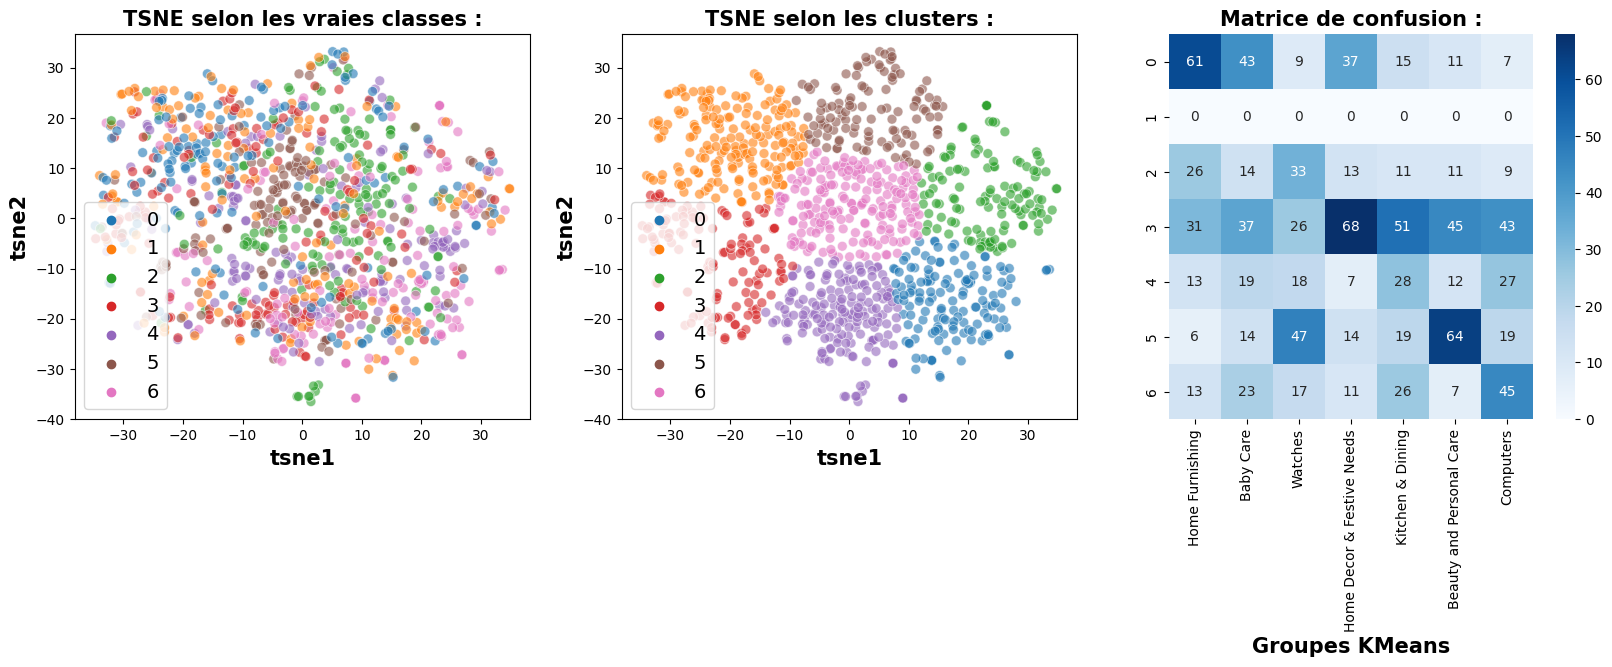

La mesure de ARI est de 0.054 pour ce modèle d'extraction des features.


In [22]:
# Réduction des dimmensions :
X_PCA = PCA(im_features, 0.99)
X_tsne = TSNE(X_PCA)

# Graphiques et score ARI :
graphsTSNE(X_tsne)

### 4.1.3 : Machine Learning

In [23]:
X = X_PCA
y = df['TreeNiv1']

In [24]:
# Machine Learning :
X_train, X_test, y_train, y_test = TrainTest (X, y)
Regression = RL(X_train, y_train, X_test, y_test)
DT = DecisionTree(X_train, y_train, X_test, y_test)
KNNs = KNN(X_train, y_train, X_test, y_test)
RF = RandomForest(X_train, y_train, X_test, y_test)
SVMC = SVM(X_train, y_train, X_test, y_test)

# Tableau de résultats
Resultats = pd.DataFrame()
Models = ['Regression', 'DT', 'KNNs', 'RF', 'SVMC']
for model in Models :
    Res = pd.DataFrame(locals()[model]).T.rename(columns = {0:'AccuracyTrain', 1:'AccuracyTest'}).rename(index = {0 : str(model)})
    Resultats = pd.concat([Resultats, Res])
Resultats.sort_values('AccuracyTest', ascending = False)

,AccuracyTrain,AccuracyTest
SVMC,0.965,0.470
KNNs,1.000,0.432
RF,0.860,0.419
Regression,0.510,0.410
DT,0.419,0.235


## 4.2 : CNN Transfer Learning

### 4.2.1 : Extraction des features des images 

In [25]:
base_model = VGG16()
model = Model(inputs = base_model.inputs, outputs = base_model.layers[-2].output)

images_features = []
i=0 
for image_file in tqdm.tqdm(df['image']):
    i +=1
    image = load_img(path + image_file, target_size=(224, 224))
    image = img_to_array(image) 
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    images_features.append(model.predict(image, verbose=0)[0])
    
images_features = np.asarray(images_features)

100%|██████████████████████████████████████████████████████████████████████████████| 1050/1050 [06:24<00:00,  2.73it/s]


### 4.2.2 : Réduction des dimensions et etude graphique des clusters

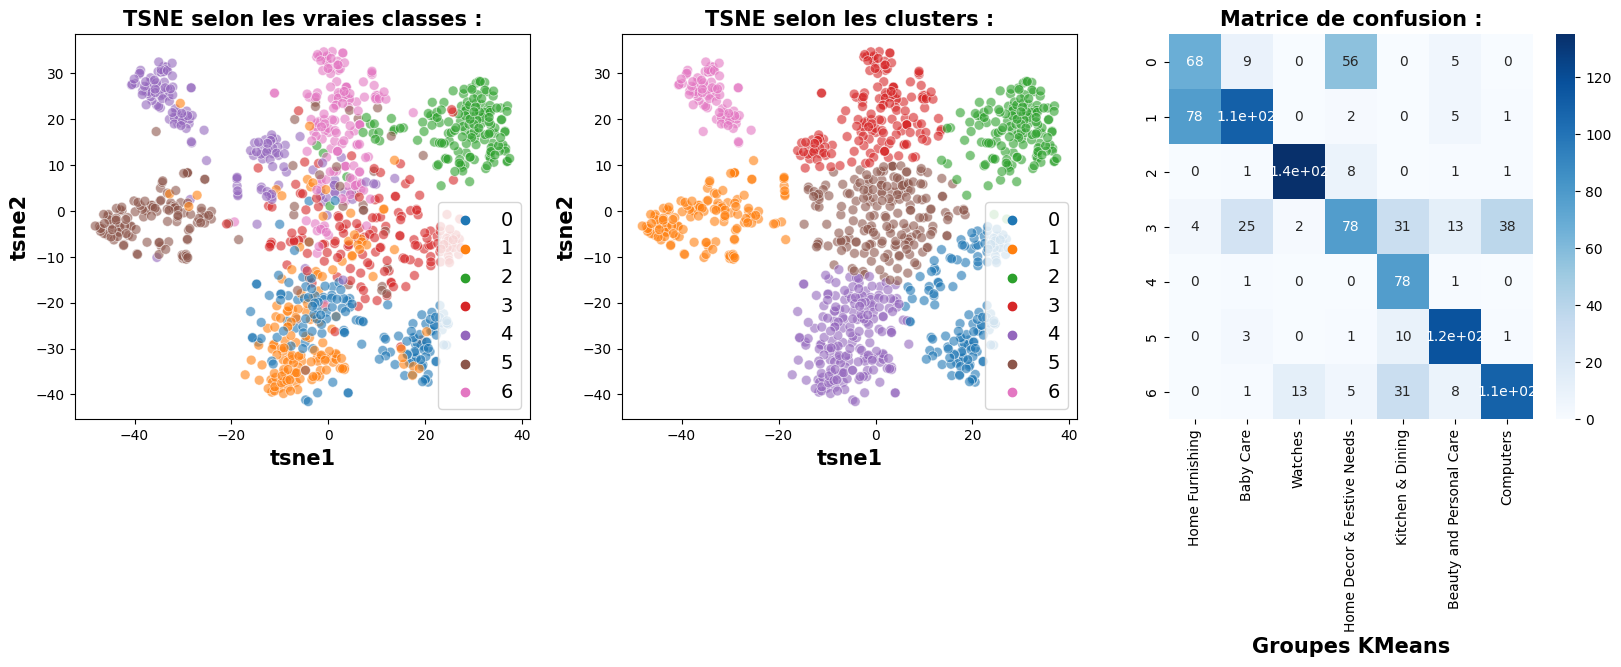

La mesure de ARI est de 0.451 pour ce modèle d'extraction des features.


In [26]:
# Réduction des dimmensions :
X_PCA = PCA(images_features, 0.99)
X_tsne = TSNE(X_PCA)

# Graphiques et score ARI :
graphsTSNE(X_tsne)

### 4.2.3 : Machine Learning et prédictions

In [27]:
X = X_PCA
y = df['TreeNiv1']

In [28]:
# Machine Learning :
X_train, X_test, y_train, y_test = TrainTest (X, y)
Regression = RL(X_train, y_train, X_test, y_test)
DT = DecisionTree(X_train, y_train, X_test, y_test)
KNNs = KNN(X_train, y_train, X_test, y_test)
RF = RandomForest(X_train, y_train, X_test, y_test)
SVMC = SVM(X_train, y_train, X_test, y_test)

# Tableau de résultats
Resultats = pd.DataFrame()
Models = ['Regression', 'DT', 'KNNs', 'RF', 'SVMC']
for model in Models :
    Res = pd.DataFrame(locals()[model]).T.rename(columns = {0:'AccuracyTrain', 1:'AccuracyTest'}).rename(index = {0 : str(model)})
    Resultats = pd.concat([Resultats, Res])
Resultats.sort_values('AccuracyTest', ascending = False)

,AccuracyTrain,AccuracyTest
SVMC,1.000,0.867
Regression,1.000,0.851
KNNs,0.815,0.819
RF,0.973,0.800
DT,0.703,0.622


# 5 : Test avec les features du NLP et de l'imagerie

## 5.1 : Test en couplant les données de USE et de CNN

In [30]:
# Merge des extraction NLP et I
ExtractCNN = pd.DataFrame(images_features)
ExtractUSE = pd.read_csv('ExtractUSE.csv')
NLPI = pd.merge(ExtractCNN, ExtractUSE, left_index = True, right_index = True)

### 5.1.1 : Réduction des dimensions et etude graphique des clusters

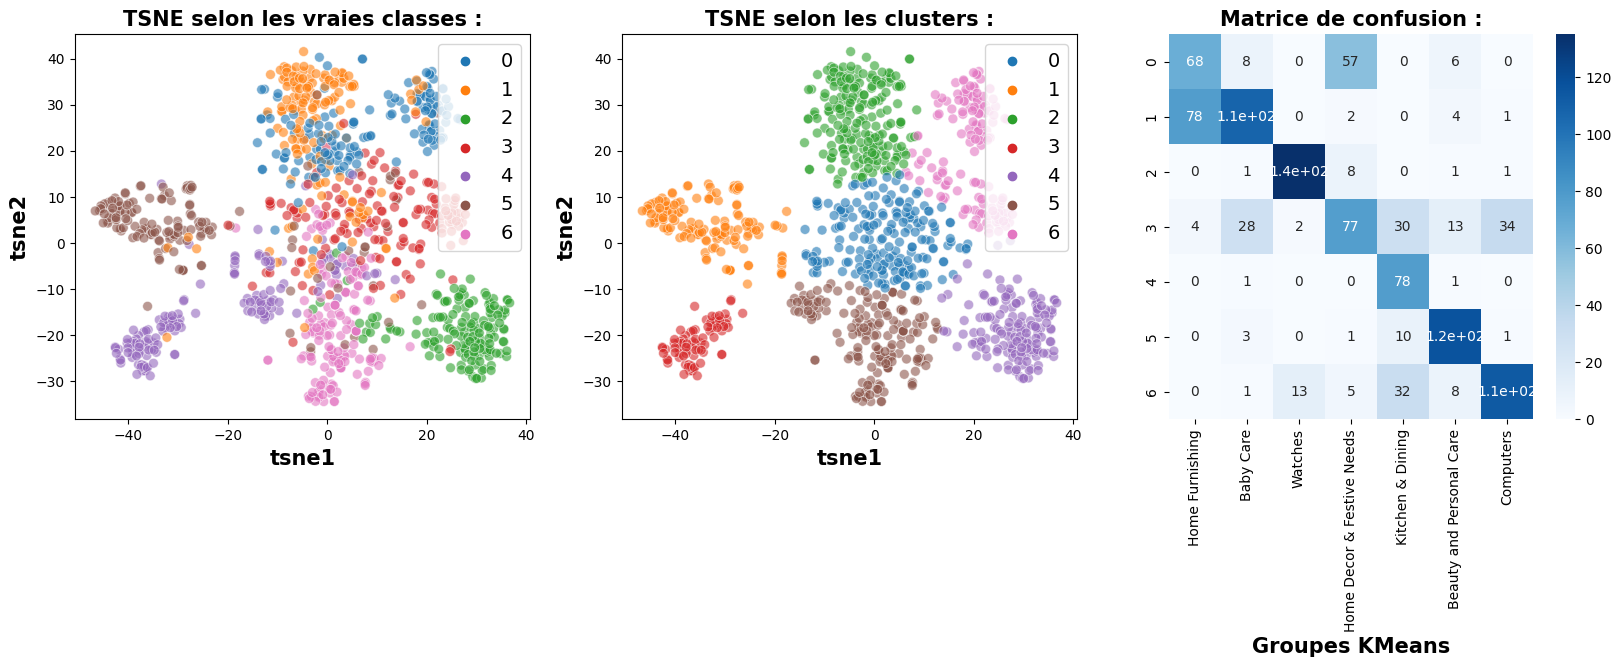

La mesure de ARI est de 0.454 pour ce modèle d'extraction des features.


In [31]:
# Réduction des dimmensions :
X_PCA = PCA(NLPI.to_numpy(), 0.99)
X_tsne = TSNE(X_PCA)

# Graphiques et score ARI :
graphsTSNE(X_tsne)

### 5.1.2 : Machine Learning et prédictions

In [32]:
X = X_PCA
y = df['TreeNiv1']

In [33]:
# Machine Learning :
X_train, X_test, y_train, y_test = TrainTest (X, y)
Regression = RL(X_train, y_train, X_test, y_test)
DT = DecisionTree(X_train, y_train, X_test, y_test)
KNNs = KNN(X_train, y_train, X_test, y_test)
RF = RandomForest(X_train, y_train, X_test, y_test)
SVMC = SVM(X_train, y_train, X_test, y_test)

# Tableau de résultats
Resultats = pd.DataFrame()
Models = ['Regression', 'DT', 'KNNs', 'RF', 'SVMC']
for model in Models :
    Res = pd.DataFrame(locals()[model]).T.rename(columns = {0:'AccuracyTrain', 1:'AccuracyTest'}).rename(index = {0 : str(model)})
    Resultats = pd.concat([Resultats, Res])
Resultats.sort_values('AccuracyTest', ascending = False)

,AccuracyTrain,AccuracyTest
SVMC,1.000,0.867
Regression,1.000,0.851
KNNs,0.815,0.819
RF,0.969,0.787
DT,0.694,0.622


- **Au final il utilise surtout les features du modéle I par rapport au modéle NLP.**

## 5.2 : Analyse des résultats via CNN et CountVectorizer :

### 5.2.1 : Résultats CV

In [34]:
# bag of words :
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer().fit(df['DescriptionGlobaleToken']) # max_features = 2 a ajouter si besoin.
sparse_matrix = vectorizer.transform(df['DescriptionGlobaleToken'])
sparse_matrix

<1050x4140 sparse matrix of type '<class 'numpy.int64'>'
	with 32702 stored elements in Compressed Sparse Row format>

In [35]:
# Réduction des dimensions (le PCA ne marchant pas sur des sparse_matrix):
svd = TruncatedSVD(n_components = 1000, random_state=42)
X = svd.fit_transform(sparse_matrix)

In [36]:
X = X
y = df['TreeNiv1']

In [37]:
# Machine Learning :
X_train, X_test, y_train, y_test = TrainTest (X, y)

modelCV = LogisticRegression(max_iter = 1000).fit(X_train, y_train)
df['PredictNLP'] = modelCV.predict(X)

### 5.2.2 : Résultats CNN

In [38]:
# Réduction des dimmensions :
X_PCA = PCA(images_features, 0.99)

In [39]:
X2 = X_PCA
y2 = df['TreeNiv1']

In [40]:
# Machine Learning :
X_train, X_test, y_train, y_test = TrainTest (X2, y2)

modelCNN = LogisticRegression(max_iter = 1000).fit(X_train, y_train)
df['PredictCNN'] = modelCNN.predict(X2)

### 5.2.3 : Comparaison des deux approches vs les résultats réels

In [41]:
Comparaison = df[['TreeNiv1','PredictNLP','PredictCNN']]
print(round((len(Comparaison[Comparaison['TreeNiv1'] != Comparaison['PredictNLP']])/len(Comparaison)*100),2))
print(round((len(Comparaison[Comparaison['TreeNiv1'] != Comparaison['PredictCNN']])/len(Comparaison)*100),2))
print(round((len(Comparaison[Comparaison['PredictCNN'] != Comparaison['PredictNLP']])/len(Comparaison)*100),2))

1.43
4.48
5.05


- **Les résultats les plus précis sont ceux du NLP.**
- **Il y a une différence de prédiction entre le NLP et l'imagerie.**

In [42]:
print(len(Comparaison[Comparaison['TreeNiv1'] != Comparaison['PredictNLP']]))
Comparaison = Comparaison[Comparaison['TreeNiv1'] != Comparaison['PredictNLP']]
print(len(Comparaison[Comparaison['TreeNiv1'] != Comparaison['PredictCNN']]))
Comparaison = Comparaison[Comparaison['TreeNiv1'] != Comparaison['PredictCNN']]

15
7


- **On passe de 15 à 7 mauvaises réponses si on utilise les deux approches.**

In [43]:
CV = pd.DataFrame(modelCV.predict_proba(X))
CNN = pd.DataFrame(modelCNN.predict_proba(X2))

### 5.2.4 : Test cumule des deux approches :

In [44]:
Test = (CV + CNN)/2
Groupe = []
for i in range(len(Test)):
    Groupe.append(Test.iloc[i:i+1].T.sort_values(i).index[-1])

    
pd.merge(Comparaison, pd.DataFrame(Groupe), right_index = True, left_index = True)

,TreeNiv1,PredictNLP,PredictCNN,0
36,3,5,1,5
300,4,3,1,1
426,1,3,6,6
638,4,5,0,0
651,1,0,3,3
669,1,0,0,0
920,0,1,1,1


- **On ne récupére pas plus de bonnes prédiction comme ça.**

In [45]:
CV.iloc[i:i+1].T.sort_values(i).index[-2]

4

In [46]:
Groupe = []
Groupe2 = []
Groupe3 = []
for i in range(len(CV)):
    Groupe.append(CV.iloc[i:i+1].T.sort_values(i).index[-1])
    Groupe2.append(CV.iloc[i:i+1].T.sort_values(i).index[-2])
    Groupe3.append(CV.iloc[i:i+1].T.sort_values(i).index[-3])

Test2 = pd.DataFrame((zip(df['TreeNiv1'], Groupe, Groupe2, Groupe3)), columns = ['CategReel','Best1', 'Best2', 'Best3'])
print('Il y a {} produits qui ne sont pas estimé dans la bonne catégorie.'.format(len(Test2[Test2['CategReel'] != Test2['Best1']])))
Test2 = Test2[Test2['CategReel'] != Test2['Best1']]
print("Il y a {} produits qui ne sont pas estimé dans l'option N°2.".format(len(Test2[Test2['CategReel'] != Test2['Best2']])))
Test2 = Test2[Test2['CategReel'] != Test2['Best2']]
print("Il y a {} produits qui ne sont pas estimé dans l'option N°3.".format(len(Test2[Test2['CategReel'] != Test2['Best3']])))

Il y a 15 produits qui ne sont pas estimé dans la bonne catégorie.
Il y a 4 produits qui ne sont pas estimé dans l'option N°2.
Il y a 2 produits qui ne sont pas estimé dans l'option N°3.
